# 8.1 LSTM으로 텍스트 생성하기

## 8.1.4 글자 수준의 LSTM 텍스트 생성 모델 구현

In [0]:
# 원본 텍스트 파일을 내려받아 파싱하기
import keras
import numpy as np

path = keras.utils.get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('말뭉치 크기:', len(text))

Using TensorFlow backend.


말뭉치 크기: 600893


In [0]:
# 글자 시퀀스 벡터화하기
maxlen = 60  # 60개 글자로 된 시퀀스를 추출합니다.
step = 3  # 세 글자씩 건너 뛰면서 새로운 시퀀스를 샘플링합니다.

sentences = [] # 추출한 시퀀스를 담을 리스트   

next_chars = []   # 타깃(시퀀스 다음 글자)을 담을 리스트

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('시퀀스 개수:', len(sentences))

chars = sorted(list(set(text)))  # 말뭉치에서 고유한 글자를 담은 리스트
print('고유한 글자:', len(chars))
char_indices = dict((char, chars.index(char)) for char in chars)  # chars 리스트에 있는 글자와 글자의 인덱스를 매핑한 딕셔너리

# 글자를 원-핫 인코딩하여 0과 1의 이진 배열로 바꿉니다.
print('벡터화...')  
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

시퀀스 개수: 200278
고유한 글자: 57
벡터화...


In [0]:
# 다음 글자를 예측하기 위한 단일 LSTM 모델
from keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

In [0]:
# 모델 컴파일 설정하기
optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [0]:
# 모델의 예측이 주어졌을 때 새로운 글자를 샘플링하는 함수
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [0]:
# 텍스트 생성 루프
import random
import sys

random.seed(42)
start_index = random.randint(0, len(text) - maxlen - 1)

# 60 에포크 동안 모델을 훈련합니다
for epoch in range(1, 60):
    print('에포크', epoch)
    # 데이터에서 한 번만 반복해서 모델을 학습합니다
    model.fit(x, y, batch_size=128, epochs=1)

    # 무작위로 시드 텍스트를 선택합니다
    seed_text = text[start_index: start_index + maxlen]
    print('--- 시드 텍스트: "' + seed_text + '"')

    # 여러가지 샘플링 온도를 시도합니다
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ 온도:', temperature)
        generated_text = seed_text
        sys.stdout.write(generated_text)

        # 시드 텍스트에서 시작해서 400개의 글자를 생성합니다
        for i in range(400):
            # 지금까지 생성된 글자를 원-핫 인코딩으로 바꿉니다
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            # 다음 글자를 샘플링합니다
            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

에포크 1
Epoch 1/1
200278/200278 [==============================] - 332s 2ms/step - loss: 1.9618
--- 시드 텍스트: "the slowly ascending ranks and classes, in which,
through fo"
------ 온도: 0.2
the slowly ascending ranks and classes, in which,
through for the proble of the sense of the desire of the sense the self-conselve of the will which a man of the self-conselves of the self-conselves of the manity of the self-conselved to the sense the more and with the self-conselve of the man which is a man which a man of the self-conselves to the sense of the self-conselves of the consequent of the sense of the consequent of the self-conscient of the sen
------ 온도: 0.5
the slowly ascending ranks and classes, in which,
through for man the probection of the sour of the men tool to the sense the more and main of which he sense the self-conselves with the proble the concention and superience of the degeal to and conclusion and something the in lights of the caud of the coured as the sense the self-and any t

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


e but a heart the self-contempthy in a such and most consequence, and but a demands the same the entire and praise of the same the same conscience of prosight in the masters of self convinted the man has bee
------ 온도: 1.0
the slowly ascending ranks and classes, in which,
through form and worldiness: "every beliefting stee untoldiere, should mild of jeapow affher called, in it has a the wishor of a cognizing example
of dis" and that the buting the goes ideas of its, to attains established by a crejuries to the self-danger and that is a igkes, understand
new how there are woman hitherto growing condition inmpisting and very german estimation of world astronation is refeet eme
------ 온도: 1.2
the slowly ascending ranks and classes, in which,
through force of theo
was, as asside procefs who are
could be kinlate, will
sgearification towards and tegaties,
wonalini chycas, very moral for
othirsi our sentiment
of eyest
rywdomness, he coves to all the restading old
immediate about the best-re. 

# 8.2 딥드림

## 8.2.1 케라스 딥드림 구현

In [0]:
# 사전 훈련된 입셉션 V3 모델 로드하기
from keras.applications import inception_v3
from keras import backend as K

# 모델을 훈련하지 않습니다. 이 명령은 모든 훈련 연산을 비활성화합니다
K.set_learning_phase(0)

# 합성곱 기반층만 사용한 인셉션 V3 네트워크를 만듭니다. 사전 훈련된 ImageNet 가중치와 함께 모델을 로드합니다
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

In [0]:
# 딥드림 설정하기

# 층 이름과 계수를 매핑한 딕셔너리.
# 최대화하려는 손실에 층의 활성화가 기여할 양을 정합니다.
# 층 이름은 내장된 인셉션 V3 애플리케이션에 하드코딩되어 있는 것입니다.
# model.summary()를 사용하면 모든 층 이름을 확인할 수 있습니다
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

In [0]:
# 최대화할 손실 정의하기

# 층 이름과 층 객체를 매핑한 딕셔너리를 만듭니다.
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# 손실을 정의하고 각 층의 기여분을 이 스칼라 변수에 추가할 것입니다
loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    # 층의 출력을 얻습니다
    activation = layer_dict[layer_name].output

    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    # 층 특성의 L2 노름의 제곱을 손실에 추가합니다. 이미지 테두리는 제외하고 손실에 추가합니다.
    loss =+ coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [0]:
# 경사 상승법 과정

# 이 텐서는 생성된 딥드림 이미지를 저장합니다
dream = model.input

# 손실에 대한 딥드림 이미지의 그래디언트를 계산합니다
grads = K.gradients(loss, dream)[0]

# 그래디언트를 정규화합니다(이 기교가 중요합니다)
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# 주어진 입력 이미지에서 손실과 그래디언트 값을 계산할 케라스 Function 객체를 만듭니다
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

# 이 함수는 경사 상승법을 여러 번 반복하여 수행합니다
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...', i, '번째 손실 :', loss_value)
        x += step * grad_values
    return x

In [0]:
# 유틸리티 함수
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    image.save_img(fname, pil_img)


def preprocess_image(image_path):
    # 사진을 열고 크기를 줄이고 인셉션 V3가 인식하는 텐서 포맷으로 변환하는 유틸리티 함수
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # 넘파이 배열을 적절한 이미지 포맷으로 변환하는 유틸리티 함수
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        # inception_v3.preprocess_input 함수에서 수행한 전처리 과정을 복원합니다
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
# 연속적인 스케일에 걸쳐 경사 상승법 실행하기
import numpy as np

# 하이퍼파라미터를 바꾸면 새로운 효과가 만들어집니다
step = 0.01  # 경상 상승법 단계 크기
num_octave = 3  # 경사 상승법을 실행할 스케일 단계 횟수
octave_scale = 1.4  # 스케일 간의 크기 비율
iterations = 20  # 스케일 단계마다 수행할 경사 상승법 횟수

# 손실이 10보다 커지면 이상한 그림이 되는 것을 피하기 위해 경사 상승법 과정을 중지합니다
max_loss = 10.

# 사용할 이미지 경로를 씁니다
base_image_path = '/content/datasets/original_photo_deep_dream.jpg'

# 기본 이미지를 넘파이 배열로 로드합니다
img = preprocess_image(base_image_path)

# 경사 상승법을 실행할 스케일 크기를 정의한 튜플의 리스트를 준비합니다
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# 이 리스트를 크기 순으로 뒤집습니다
successive_shapes = successive_shapes[::-1]

# 이미지의 넘파이 배열을 가장 작은 스케일로 변경합니다
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('처리할 이미지 크기', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='/content/datasets/final_dream.png')


처리할 이미지 크기 (178, 178)
... 0 번째 손실 : 0.08422812
... 1 번째 손실 : 0.13463995
... 2 번째 손실 : 0.18777871
... 3 번째 손실 : 0.24311297
... 4 번째 손실 : 0.29969138
... 5 번째 손실 : 0.35345596
... 6 번째 손실 : 0.43850398
... 7 번째 손실 : 0.5270229
... 8 번째 손실 : 0.6048345
... 9 번째 손실 : 0.6954611
... 10 번째 손실 : 0.7919404
... 11 번째 손실 : 0.9493565
... 12 번째 손실 : 1.1211686
... 13 번째 손실 : 1.2477558
... 14 번째 손실 : 1.411928
... 15 번째 손실 : 1.594163
... 16 번째 손실 : 1.7550504
... 17 번째 손실 : 1.9159964
... 18 번째 손실 : 2.092357
... 19 번째 손실 : 2.274946
처리할 이미지 크기 (250, 250)
... 0 번째 손실 : 0.20317526
... 1 번째 손실 : 0.38647488
... 2 번째 손실 : 0.58253473
... 3 번째 손실 : 0.79338443
... 4 번째 손실 : 0.9362453
... 5 번째 손실 : 0.98986566
... 6 번째 손실 : 1.3238472
... 7 번째 손실 : 1.4715093
... 8 번째 손실 : 1.7229948
... 9 번째 손실 : 1.8730423
... 10 번째 손실 : 2.0342236
... 11 번째 손실 : 2.2268329
... 12 번째 손실 : 2.3546317
... 13 번째 손실 : 2.5475173
... 14 번째 손실 : 2.8930275
... 15 번째 손실 : 2.9877641
... 16 번째 손실 : 3.2538788
... 17 번째 손실 : 3.3365197
... 18 번째 손실 : 3.6

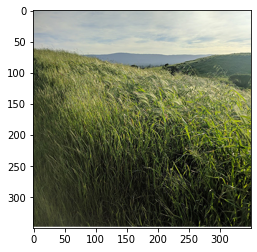

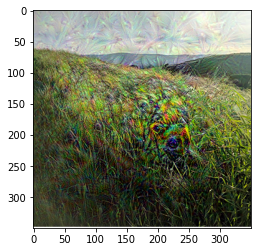

In [0]:
from matplotlib import pyplot as plt

plt.imshow(plt.imread(base_image_path))
plt.figure()

plt.imshow(deprocess_image(np.copy(img)))
plt.show()

# 8.3 뉴럴 스타일 트랜스퍼

## 8.3.3 케라스에서 뉴럴 스타일 트랜스퍼 구현하기

In [0]:
# 변수 초깃값 정의하기
from keras.preprocessing.image import load_img, img_to_array, save_img

# 변환하려는 이미지 경로
target_image_path = '/content/datasets/portrait.jpg'
# 스타일 이미지 경로
style_reference_image_path = '/content/datasets/popova.jpg'

# 생성된 사진의 차원
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [0]:
# 유틸리티 함수
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # ImageNet의 평균 픽셀 값을 더합니다
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
# 사전 훈련된 VGG19 네트워크를 로딩하고 3개 이미지에 적용하기
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# 생성된 이미지를 담을 플레이스홀더
combination_image = K.placeholder((1, img_height, img_width, 3))

# 세 개의 이미지를 하나의 배치로 합칩니다
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# 세 이미지의 배치를 입력으로 받는 VGG 네트워크를 만듭니다.
# 이 모델은 사전 훈련된 ImageNet 가중치를 로드합니다
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('모델 로드 완료.')

모델 로드 완료.


In [0]:
# 콘텐츠 손실
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [0]:
# 스타일 손실
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
# 총 변위 손실
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [0]:
# 최소화할 최종 손실 정의하기
# 층 이름과 활성화 텐서를 매핑한 딕셔너리
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# 콘텐츠 손실에 사용할 층
content_layer = 'block5_conv2'
# 스타일 손실에 사용할 층
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# 손실 항목의 가중치 평균에 사용할 가중치
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# 모든 손실 요소를 더해 하나의 스칼라 변수로 손실을 정의합니다
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss =+ content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss =+ (style_weight / len(style_layers)) * sl
loss =+ total_variation_weight * total_variation_loss(combination_image)

In [0]:
# 경사 하강법 단계 설정하기
# 손실에 대한 생성된 이미지의 그래디언트를 구합니다
grads = K.gradients(loss, combination_image)[0]

# 현재 손실과 그래디언트의 값을 추출하는 케라스 Function 객체입니다
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [0]:
# 스타일 트랜스퍼 반복 루프
from scipy.optimize import fmin_l_bfgs_b
import time

result_prefix = 'style_transfer_result'
iterations = 20

# 뉴럴 스타일 트랜스퍼의 손실을 최소화하기 위해 생성된 이미지에 대해 L-BFGS 최적화를 수행합니다
# 초기 값은 타깃 이미지입니다
# scipy.optimize.fmin_l_bfgs_b 함수가 벡터만 처리할 수 있기 때문에 이미지를 펼칩니다.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('반복 횟수:', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('현재 손실 값:', min_val)
    # 생성된 현재 이미지를 저장합니다
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
    print('저장 이미지: ', fname)
    print('%d 번째 반복 완료: %ds' % (i, end_time - start_time))

반복 횟수: 0
현재 손실 값: 1232.3397
저장 이미지:  style_transfer_result_at_iteration_0.png
0 번째 반복 완료: 3s
반복 횟수: 1
현재 손실 값: 384.84488
저장 이미지:  style_transfer_result_at_iteration_1.png
1 번째 반복 완료: 3s
반복 횟수: 2
현재 손실 값: 190.9184
저장 이미지:  style_transfer_result_at_iteration_2.png
2 번째 반복 완료: 3s
반복 횟수: 3
현재 손실 값: 111.69637
저장 이미지:  style_transfer_result_at_iteration_3.png
3 번째 반복 완료: 3s
반복 횟수: 4
현재 손실 값: 77.616776
저장 이미지:  style_transfer_result_at_iteration_4.png
4 번째 반복 완료: 3s
반복 횟수: 5
현재 손실 값: 55.973557
저장 이미지:  style_transfer_result_at_iteration_5.png
5 번째 반복 완료: 3s
반복 횟수: 6
현재 손실 값: 43.95815
저장 이미지:  style_transfer_result_at_iteration_6.png
6 번째 반복 완료: 3s
반복 횟수: 7
현재 손실 값: 36.000572
저장 이미지:  style_transfer_result_at_iteration_7.png
7 번째 반복 완료: 3s
반복 횟수: 8
현재 손실 값: 30.388662
저장 이미지:  style_transfer_result_at_iteration_8.png
8 번째 반복 완료: 3s
반복 횟수: 9
현재 손실 값: 25.902613
저장 이미지:  style_transfer_result_at_iteration_9.png
9 번째 반복 완료: 3s
반복 횟수: 10
현재 손실 값: 22.74113
저장 이미지:  style_transfer_result_at_iteration_

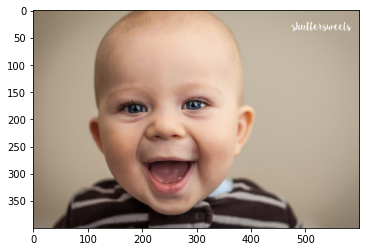

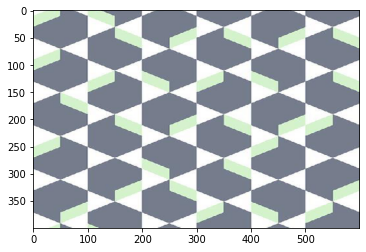

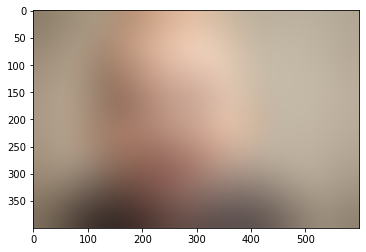

In [0]:
from matplotlib import pyplot as plt

# 콘텐츠 이미지
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# 스타일 이미지
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# 생성된 이미지
plt.imshow(img)
plt.show()

# 8.4 변이형 오토인코더를 사용한 이미지 생성

In [0]:
# VAE 인코더 네트워크
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # 잠재 공간의 차원: 2D 평면

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Using TensorFlow backend.


In [0]:
# 잠재 공간 샘플링 함수
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [0]:
# 잠재 공간 포인트를 이미지로 매핑하는 VAE 디코더 네트워크
# Input에 z를 주입합니다
decoder_input = layers.Input(K.int_shape(z)[1:])

# 입력을 업샘플링합니다
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# 인코더 모델의 마지막 Flatten 층 직전의 특성 맵과 같은 크기를 가진 특성 맵으로 z의 크기를 바꿉니다
x = layers.Reshape(shape_before_flattening[1:])(x)

# Conv2DTranspose 층과 Conv2D 층을 사용해 z를 원본 입력 이미지와 같은 크기의 특성 맵으로 디코딩합니다
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)
# 특성 맵의 크기가 원본 입력과 같아집니다

# 디코더 모델 객체를 만듭니다
decoder = Model(decoder_input, x)

# 모델에 z를 주입하면 디코딩된 z를 출력합니다
z_decoded = decoder(z)

In [0]:
# VAE 손실을 계산하기 위해 직접 만든 층
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # 출력 값을 사용하지 않습니다
        return x

# 입력과 디코딩된 출력으로 이 층을 호출하여 모델의 최종 출력을 얻습니다
y = CustomVariationalLayer()([input_img, z_decoded])

In [0]:
# VAE 훈련하기
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

# MNIST 숫자 이미지에서 VAE를 훈련합니다
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


11493376/11490434 [==============================] - 0s 0us/step
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 379s 6ms/step - loss: 0.2114 - val_loss: 0.1961
Epoch 2/10
60000/60000 [==============================] - 378s 6ms/step - loss: 0.1944 - val_loss: 0.1936
Epoch 3/10
60000/60000 [==============================] - 377s 6ms/step - loss: 0.1912 - val_loss: 0.1895
Epoch 4/10
60000/60000 [==============================] - 366s 6ms/step - loss: 0.1890 - val_loss: 0.1885
Epoch 5/10
60000/60000 [==============================] - 359s 6ms/step - loss: 0.1873 - val_loss: 0.1866
Epoch 6/10
60000/60000 [==============================] - 363s 6ms/step - loss: 0.1866 - val_loss: 0.1855
Epoch 7/10
60000/60000 [==============================] - 364s 6ms/step - loss: 0.1852 - val_loss: 0.1851
Epoch 8/10
60000/60000 [==============================] - 366s 6ms/step - loss: 0.1846 - val_loss: 0.1838
Epoch 9/10
60000/60000 [=============

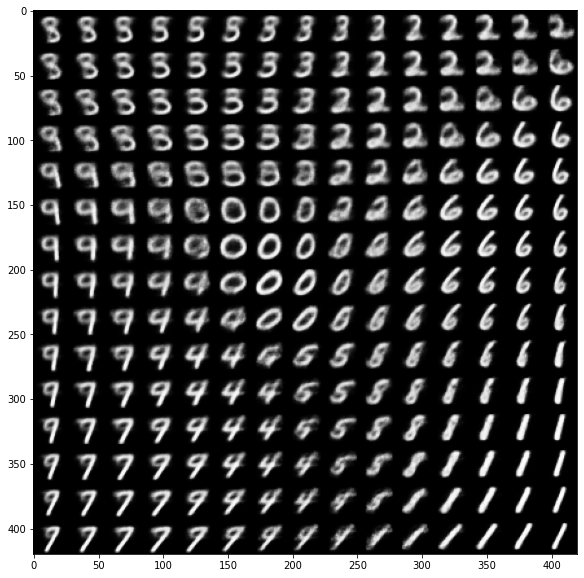

In [0]:
# 2D 잠재 공간에서 포인트 그리드를 샘플링하여 이미지로 디코딩하기
import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # 15 × 15 숫자의 그리드를 출력합니다
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# 싸이파이 ppf 함수를 사용하여 일정하게 떨어진 간격마다 잠재 변수 z의 값을 만듭니다
# 잠재 공간의 사전 확률은 가우시안입니다
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

# 8.5 적대적 생성 신경망 소개

## 8.5.3 생성자

In [0]:
# GAN 생성자 네트워크
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# 입력을 16 × 16 크기의 128개 채널을 가진 특성 맵으로 변환합니다
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# 합성곱 층을 추가합니다
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 32 × 32 크기로 업샘플링합니다
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# 합성곱 층을 더 추가합니다
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 32 × 32 크기의 1개 채널을 가진 특성 맵을 생성합니다
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Using TensorFlow backend.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048

## 8.5.4 판별자

In [0]:
# GAN 판별자 네트워크
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# 드롭아웃 층을 넣는 것이 아주 중요합니다!
x = layers.Dropout(0.4)(x)

# 분류 층
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# 옵티마이저에서 (값을 지정하여) 그래디언트 클리핑을 사용합니다
# 안정된 훈련을 위해서 학습률 감쇠를 사용합니다
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6, 6, 128)         0   

## 8.5.5 적대적 네트워크

In [0]:
# 적대적 네트워크
# 판별자의 가중치가 훈련되지 않도록 설정합니다(gan 모델에만 적용됩니다)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## 8.5.6 DCGAN 훈련방법

In [0]:
# GAN 훈련 구현하기
import os
from keras.preprocessing import image

# CIFAR10 데이터를 로드합니다
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# 개구리 이미지를 선택합니다(클래스 6)
x_train = x_train[y_train.flatten() == 6]

# 데이터를 정규화합니다
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = '/content/datasets/gan_images/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# 훈련 반복 시작
start = 0
for step in range(iterations):
    # 잠재 공간에서 무작위로 포인트를 샘플링합니다
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 가짜 이미지를 디코딩합니다
    generated_images = generator.predict(random_latent_vectors)

    # 진짜 이미지와 연결합니다
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # 진짜와 가짜 이미지를 구분하여 레이블을 합칩니다
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # 레이블에 랜덤 노이즈를 추가합니다. 아주 중요합니다!
    labels += 0.05 * np.random.random(labels.shape)

    # discriminator를 훈련합니다
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # 잠재 공간에서 무작위로 포인트를 샘플링합니다
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 모두 “진짜 이미지"라고 레이블을 만듭니다
    misleading_targets = np.zeros((batch_size, 1))

    # generator를 훈련합니다(gan 모델에서 discriminator의 가중치는 동결됩니다)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # 중간 중간 저장하고 그래프를 그립니다
    if step % 100 == 0:
        # 모델 가중치를 저장합니다
        gan.save_weights('gan.h5')

        # 측정 지표를 출력합니다
        print('스텝 %s에서 판별자 손실: %s' % (step, d_loss))
        print('스텝 %s에서 적대적 손실: %s' % (step, a_loss))

        # 생성된 이미지 하나를 저장합니다
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # 비교를 위해 진짜 이미지 하나를 저장합니다
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


스텝 0에서 판별자 손실: 0.6837304
스텝 0에서 적대적 손실: 0.6836405
스텝 100에서 판별자 손실: 0.5375814
스텝 100에서 적대적 손실: 4.04029
스텝 200에서 판별자 손실: 0.7106468
스텝 200에서 적대적 손실: 0.74604404
스텝 300에서 판별자 손실: 0.6855219
스텝 300에서 적대적 손실: 0.7537494
스텝 400에서 판별자 손실: 0.6700034
스텝 400에서 적대적 손실: 0.8435341
스텝 500에서 판별자 손실: 0.683877
스텝 500에서 적대적 손실: 0.79661953
스텝 600에서 판별자 손실: 0.6841162
스텝 600에서 적대적 손실: 1.1323128


In [0]:
import matplotlib.pyplot as plt

# 잠재 공간에서 랜덤한 포인트를 샘플링합니다
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# 가짜 이미지로 디코딩합니다
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()